In [1]:
%%javascript
require(["codemirror/keymap/sublime", "notebook/js/cell", "base/js/namespace"],
    function(sublime_keymap, cell, IPython) {
        cell.Cell.options_default.cm_config.keyMap = 'sublime';
        var cells = IPython.notebook.get_cells();
        for(var cl=0; cl< cells.length ; cl++){
            cells[cl].code_mirror.setOption('keyMap', 'sublime');
        }
    }
);

<IPython.core.display.Javascript object>

In [2]:
# change the cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import warnings
warnings.filterwarnings('ignore')
# make matplotlib pdf-s text recognizable by evil-Adobe
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from more_itertools import chunked
# import all relevant func and modules from a companion .py file
from supp_lib import *
# import all samples as dictionary ...
from samples import *

In [5]:
genes_df = pd.read_csv(
    "./gene_annot_data/hg19/geneAnnotationsExonUnions.bed",
    sep="\t",
    header=None,
    names = ["chr",
            "txStart",
            "txEnd",
            "geneName",
            "citationCount",
            "strand",
            "union_geneId", # "refseqId",
            "geneId",
            "geneType",
            "geneDesc",
            "cdsStart",
            "cdsEnd",
            "exonStarts",
            "exonEnds"]
)
genes_df.head()

### we'll be removing duplicated genes because they're likely unamppable and/or harder to deal with anyways ...
### there are of course expections, but will do it anyways:
geneId_grp = genes_df.groupby("geneId")
genes_df = geneId_grp.first()[geneId_grp.size() == 1].reset_index()

### Let's merge in Gene Expression level information into our gene annotation DataFrame 

In [6]:
rsem_df = pd.read_csv("merged_TPM_genes.tsv",sep="\t")[["Id","rsem.out.S442_NT"]]
# genes_Df  overlap   rsem
# ~4_300     ~23_200   ~2_500

In [7]:
genes_exp_df = pd.merge(
    rsem_df,
    genes_df,
    how = 'inner',
    left_on="Id",
    right_on="geneName"
)
genes_exp_df.head(3)

,Id,rsem.out.S442_NT,geneId,chr,txStart,txEnd,geneName,citationCount,strand,union_geneId,geneType,geneDesc,cdsStart,cdsEnd,exonStarts,exonEnds
0,C9orf152,0,401546,chr9,112961844,112970439,C9orf152,5,-,union_401546,protein-coding,chromosome 9 open reading frame 152,112963227,112969859,"112961844,112969666","112963754,112970439"
1,RPS11,4520,6205,chr19,49999690,50002965,RPS11,149,+,union_6205,protein-coding,ribosomal protein S11,49999713,50002892,"49999690,50000450,50000776,50001173,50002768","49999728,50000582,50000852,50001303,50002965"
2,ELMO2,14,63916,chr20,44994683,45035690,ELMO2,47,-,union_63916,protein-coding,engulfment and cell motility 2,44995998,45017838,"44994683,44994689,44997529,44999081,44999990,4...","44996199,44996199,44997607,44999164,45000098,4..."


In [8]:
# columns needed for TSS/TTS bed files output:
tx_cols = ["chr", "txStart", "txEnd", "strand", "rsem.out.S442_NT"]

tx_cols_rename = {"chr":"chrom",
                  "txStart":"start",
                  "txEnd":"end",
                  "rsem.out.S442_NT":"exp"}

gdf =  genes_exp_df[tx_cols].reset_index(drop=True).rename(tx_cols_rename,axis=1)

gdf["size"] = gdf["end"] - gdf["start"]

In [9]:
gdf = gdf.sort_values(["chrom","start"])
gdf = gdf[gdf["chrom"].isin(autosomal_chroms)]
gdf = gdf.reset_index(drop=True)
gdf.head(3)

,chrom,start,end,strand,exp,size
0,chr1,11873,14409,+,0,2536
1,chr1,14361,29370,-,32,15009
2,chr1,69090,70008,+,0,918


In [10]:
fig5_samples = ["ins_CTCF",
                "ins_noCTCF",
                "ins_polII",
                "ins_nopolII",
                "ev1_CTCF",
                "ev1_noCTCF",
                "ev1_polII",
                "ev1_nopolII",
                "polII",
                'h3k4_r1',
                "mrna_ctcf",
                "mrna_noctcf"]

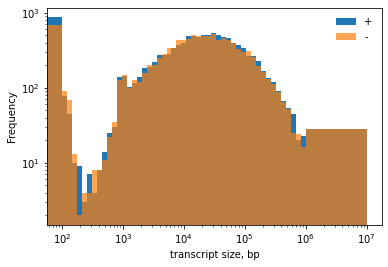

In [11]:
bins = np.r_[0,np.geomspace(100,1_000_000),10_000_000]
gdf[gdf["strand"]=="+"]["size"].plot.hist(bins=bins,log=True,label="+")
gdf[gdf["strand"]=="-"]["size"].plot.hist(bins=bins,log=True,alpha=0.7,label="-")
ax = plt.gca()
ax.set_xscale("log")
ax.set_xlabel("transcript size, bp")
ax.legend(frameon=False)

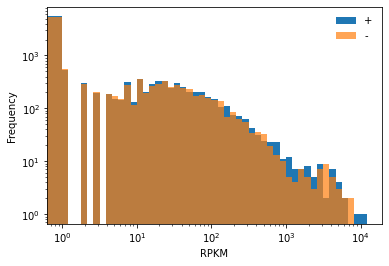

In [12]:
# actually - negative polarity genes are less expressed than tha positive strand genes ...
bins = np.r_[0,np.geomspace(1,12000)]
gdf[gdf["strand"]=="+"]["exp"].plot.hist(bins=bins,log=True,label="+")
gdf[gdf["strand"]=="-"]["exp"].plot.hist(bins=bins,log=True,alpha=0.7,label="-")
ax = plt.gca()
ax.set_xscale("log")
ax.set_xlabel("RPKM")
ax.legend(frameon=False)

In [13]:
exp_bin_edges = [0,1,10,np.inf]
exp_labels = ("no","low","high")
sizes_bin_edges = [0,50_000,np.inf]
sizes_labels = ("short","long")

gdf["gexp"] = pd.cut(
    gdf["exp"],
    bins = exp_bin_edges,
    labels = exp_labels,
    include_lowest = True
)
gdf["gsize"] = pd.cut(
    gdf["size"],
    bins = sizes_bin_edges,
    labels = sizes_labels,
    include_lowest = True
)
display(gdf.head())
display( gdf.groupby(["gexp","gsize"]).size().unstack(fill_value=0) )

,chrom,start,end,strand,exp,size,gexp,gsize
0,chr1,11873,14409,+,0,2536,no,short
1,chr1,14361,29370,-,32,15009,high,short
2,chr1,69090,70008,+,0,918,no,short
3,chr1,134772,140566,-,0,5794,no,short
4,chr1,562759,564389,-,0,1630,no,short


gsize,short,long
gexp,,
no,9492,2418
low,1842,1227
high,5035,2280


In [14]:
# extend the stacking region by the gene length on each side !
gdf["start"] = gdf["start"] - gdf["size"]
gdf["end"] = gdf["end"] + gdf["size"]

In [15]:
# 'ev1_CTCF', 'ev1_noCTCF', 'ev1_polII', 'ev1_nopolII'
def extract_ins(df,
                fname,
                bins=3000
               ):
    """
    for a BED-like DF, extract 'signal' from BW (fname) for every interval
    use "strand" information to flip "-" strand genes ...
    """
    return np.nanmean(np.asarray([
        bbi.fetch
               (
                    fname,
                    chrom,
                    start,
                    end,
                    bins=bins,
                    missing=0.0,
                    oob=np.nan,
                    summary='mean',
                )[:: (1 if strand=="+" else -1) ] # flip in place for "-" genes
      for chrom, start, end, strand, *_ in df.itertuples(index=False)
    ]),
      axis=0,                
     )


def extract_ins_noflip(df,
                fname,
                bins=3000
               ):
    """
    for a BED-like DF, extract 'signal' from BW (fname) for every interval
    no flipping ...
    """
    return np.nanmean(np.asarray([
        bbi.fetch
               (
                    fname,
                    chrom,
                    start,
                    end,
                    bins=bins,
                    missing=0.0,
                    oob=np.nan,
                    summary='mean',
                )
      for chrom, start, end, *_ in df.itertuples(index=False)
    ]),
      axis=0,                
     )


In [16]:
ctcf_df = bioframe.read_table("intersect-all-NT-CTCF-NO-G4-centered-RAD21",schema="bed3",index_col=False)
# # ctcf_df = pd.read_table("intersect-all-NT-CTCF-NO-G4-centered-RAD21",header=None)
ctcf_df = ctcf_df.sort_values(["chrom","start"])
ctcf_df = ctcf_df[ctcf_df["chrom"].isin(autosomal_chroms)]
ctcf_df = ctcf_df.reset_index(drop=True)
ctcf_df["start"] = ctcf_df["start"] - 200_000
ctcf_df["end"] = ctcf_df["end"] + 200_000
ctcf_df.head(3)

,chrom,start,end
0,chr1,-189849,210508
1,chr1,604937,1005691
2,chr1,675596,1075897


### TSS to TTS scaled profiles ...

In [17]:
# key features/signals that we want to extract for our genes ...
key_features = ['ins_rad21',
            'ins_norad21',
            'ins_mutCtr_CTCF',
            'ins_mutCtr_noCTCF',
            'ins_mutDDX_CTCF',
            'ins_mutDDX_noCTCF',
            'ins_mutTAF_CTCF',
            'ins_mutTAF_noCTCF',
            'ins_siCtr_CTCF',
            'ins_siCtr_noCTCF',
            'ins_siDDX_CTCF',
            'ins_siDDX_noCTCF',
            'ins_siTAF_CTCF',
            'ins_siTAF_noCTCF']

### Extracting Meta-gene profiles of the key-features (insulations, Chip_Seq data etc)

#### Here we extract data for + and - genes separately and flip "-" genes to orient them same way as the "+" genes ...
#### using `extract_ins` function...

In [18]:
profiles_dict = {}

# group genes by expression and size before extracting corresponding profiles of a list of features :
gene_groups = gdf.groupby(["gexp","gsize"])
for feature_name in key_features:
    print(f"extracting {feature_name} for the genes ...")
    feature_fname = samples[feature_name]["fname"]
    profiles_dict[feature_name] = gene_groups.apply( lambda sub_df: extract_ins(sub_df, feature_fname) )

extracting ins_rad21 for the genes ...
extracting ins_norad21 for the genes ...
extracting ins_mutCtr_CTCF for the genes ...
extracting ins_mutCtr_noCTCF for the genes ...
extracting ins_mutDDX_CTCF for the genes ...
extracting ins_mutDDX_noCTCF for the genes ...
extracting ins_mutTAF_CTCF for the genes ...
extracting ins_mutTAF_noCTCF for the genes ...
extracting ins_siCtr_CTCF for the genes ...
extracting ins_siCtr_noCTCF for the genes ...
extracting ins_siDDX_CTCF for the genes ...
extracting ins_siDDX_noCTCF for the genes ...
extracting ins_siTAF_CTCF for the genes ...
extracting ins_siTAF_noCTCF for the genes ...


### CTCF insulation/Rloops profiles to match the scaled TSS/TTS profiles ...

#### In this case we are not flipping profiles according to orientation (yet), so we have to use `extract_ins_noflip` function

In [19]:
CTCF_profiles_dict = {}

for feature_name in key_features:
    print(f"extracting {feature_name} for the CTCF peaks ...")
    feature_fname = samples[feature_name]["fname"]
    CTCF_profiles_dict[feature_name] = extract_ins_noflip(ctcf_df, feature_fname, bins=300)

extracting ins_rad21 for the CTCF peaks ...
extracting ins_norad21 for the CTCF peaks ...
extracting ins_mutCtr_CTCF for the CTCF peaks ...
extracting ins_mutCtr_noCTCF for the CTCF peaks ...
extracting ins_mutDDX_CTCF for the CTCF peaks ...
extracting ins_mutDDX_noCTCF for the CTCF peaks ...
extracting ins_mutTAF_CTCF for the CTCF peaks ...
extracting ins_mutTAF_noCTCF for the CTCF peaks ...
extracting ins_siCtr_CTCF for the CTCF peaks ...
extracting ins_siCtr_noCTCF for the CTCF peaks ...
extracting ins_siDDX_CTCF for the CTCF peaks ...
extracting ins_siDDX_noCTCF for the CTCF peaks ...
extracting ins_siTAF_CTCF for the CTCF peaks ...
extracting ins_siTAF_noCTCF for the CTCF peaks ...


### Normalize insulation by subtracting average flanking signal

In [20]:
ins_keys = [k for k in key_features if k.startswith("ins") ]

for feature_name in ins_keys:
    print(f"normalizing insulation {feature_name} for CTCF-peak profiles ...")
    ins_profile = CTCF_profiles_dict[feature_name]
    flank_size = int(len(ins_profile)*0.25)
    # average left and right shoulders of `flank_size` ...
    average_signal_across_flank = np.nanmean(np.r_[ins_profile[:flank_size], ins_profile[-flank_size:]])
    # subtract that average flank ...
    CTCF_profiles_dict[feature_name] = CTCF_profiles_dict[feature_name] - average_signal_across_flank
    

for feature_name in ins_keys:
    print(f"normalizing insulation {feature_name} for gene profiles ...")
    for gexp_gsize_key, ins_profile in profiles_dict[feature_name].iteritems():
        flank_size = int(len(ins_profile)*0.25)
        # average left and right shoulders of `flank_size` ...
        average_signal_across_flank = np.nanmean(np.r_[ins_profile[:flank_size], ins_profile[-flank_size:]])
        # subtract that average flank ...
        profiles_dict[feature_name][gexp_gsize_key] = ins_profile - average_signal_across_flank


normalizing insulation ins_rad21 for CTCF-peak profiles ...
normalizing insulation ins_norad21 for CTCF-peak profiles ...
normalizing insulation ins_mutCtr_CTCF for CTCF-peak profiles ...
normalizing insulation ins_mutCtr_noCTCF for CTCF-peak profiles ...
normalizing insulation ins_mutDDX_CTCF for CTCF-peak profiles ...
normalizing insulation ins_mutDDX_noCTCF for CTCF-peak profiles ...
normalizing insulation ins_mutTAF_CTCF for CTCF-peak profiles ...
normalizing insulation ins_mutTAF_noCTCF for CTCF-peak profiles ...
normalizing insulation ins_siCtr_CTCF for CTCF-peak profiles ...
normalizing insulation ins_siCtr_noCTCF for CTCF-peak profiles ...
normalizing insulation ins_siDDX_CTCF for CTCF-peak profiles ...
normalizing insulation ins_siDDX_noCTCF for CTCF-peak profiles ...
normalizing insulation ins_siTAF_CTCF for CTCF-peak profiles ...
normalizing insulation ins_siTAF_noCTCF for CTCF-peak profiles ...
normalizing insulation ins_rad21 for gene profiles ...
normalizing insulation in

#### Plotting the profiles ...

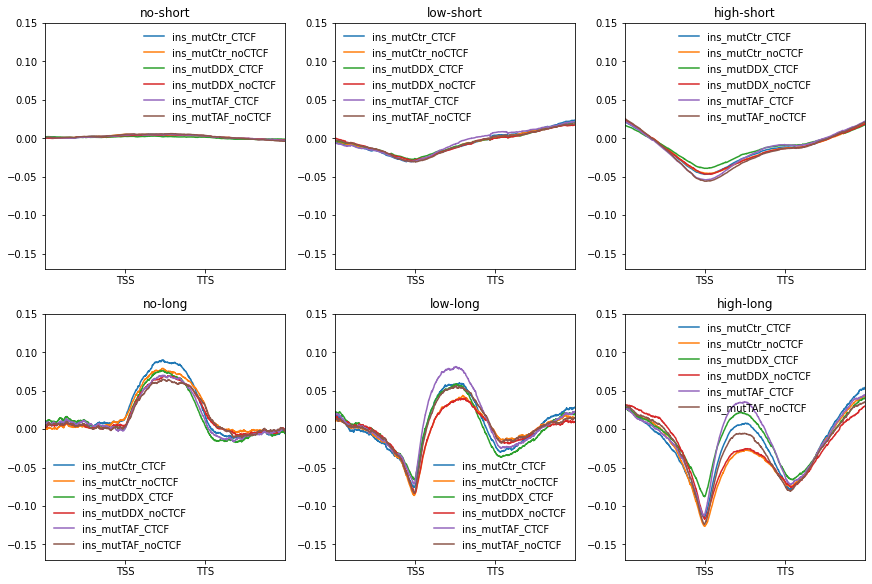

In [21]:
glens=("short","long")
gexps=("no","low","high")

mutant_keys = [k for k in key_features if k.startswith("ins_mut") ]

fig = plt.figure(figsize=(12,8),constrained_layout=True)
gs = fig.add_gridspec(len(glens),len(gexps))

for i,glen in enumerate(glens):
    for j,gexp in enumerate(gexps):
        ax = fig.add_subplot(gs[i,j])
        for feature_name in mutant_keys:
            ins_profiles = profiles_dict[feature_name]
            ax.plot(ins_profiles[(gexp,glen)],label=feature_name)
        ax.set_title(f"{gexp}-{glen}")
        ax.legend(frameon=False)
        ax.set_ylim(-0.17,.15)
        ax.set_xlim(0,3000)
        ax.set_xticks([1000,2000])
        ax.set_xticklabels(["TSS","TTS"])

### Figure 3C itself ! comparing average insulation


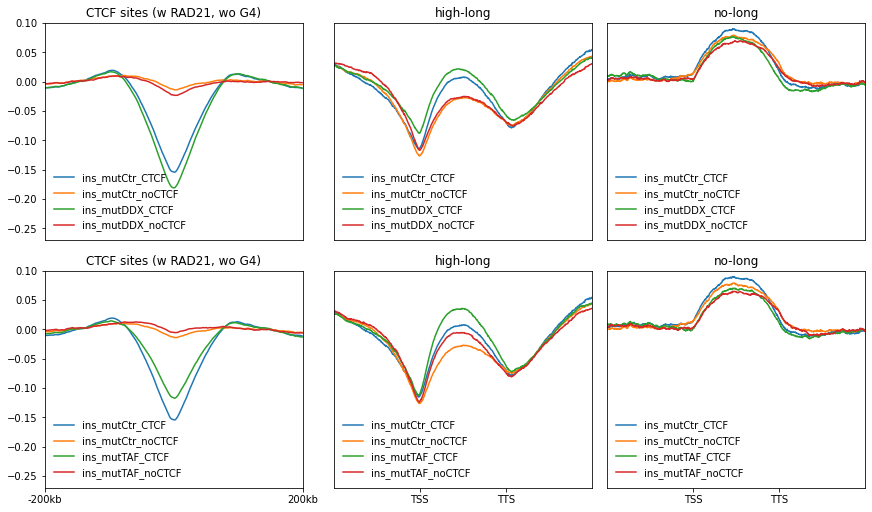

In [22]:
fig = plt.figure(figsize=(12,7),constrained_layout=True)
gs = fig.add_gridspec(2,3)
ins_ylim = (-0.27,.1)
rloop_ylim = (.7,4.5)

ins_keys_figure = [k for k in key_features if (k.startswith("ins_mutCtr") or k.startswith("ins_mutDDX")) ]
# insulation profiles around CTCF-peaks
ax = fig.add_subplot(gs[0,0])
for feature_name in ins_keys_figure:
    ins_profile = CTCF_profiles_dict[feature_name]
    ax.plot(ins_profile,label=feature_name)
ax.set_title(f"CTCF sites (w RAD21, wo G4)")
ax.legend(frameon=False)
ax.set_ylim(ins_ylim)
ax.set_xlim(0,300)
ax.set_xticks([])
ax.set_xticklabels([])

# insulation profiles around genes ...
glen="long"
gexps=("high","no")
for j, gexp in enumerate(gexps):
    ax = fig.add_subplot(gs[0,j+1])
    for feature_name in ins_keys_figure:
        ins_profiles = profiles_dict[feature_name]
        ax.plot(ins_profiles[(gexp,glen)],label=feature_name)
    ax.set_title(f"{gexp}-{glen}")
    ax.legend(frameon=False)
    ax.set_ylim(ins_ylim)
    ax.set_xlim(0,3000)
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])


ins_keys_figure = [k for k in key_features if (k.startswith("ins_mutCtr") or k.startswith("ins_mutTAF")) ]
# insulation profiles around CTCF-peaks
ax = fig.add_subplot(gs[1,0])
for feature_name in ins_keys_figure:
    ins_profile = CTCF_profiles_dict[feature_name]
    ax.plot(ins_profile,label=feature_name)
ax.set_title(f"CTCF sites (w RAD21, wo G4)")
ax.legend(frameon=False)
ax.set_ylim(ins_ylim)
ax.set_xlim(0,300)
ax.set_xticks([0,300])
ax.set_xticklabels(["-200kb","200kb"])

# insulation profiles around genes ...
glen="long"
gexps=("high","no")
for j, gexp in enumerate(gexps):
    ax = fig.add_subplot(gs[1,j+1])
    for feature_name in ins_keys_figure:
        ins_profiles = profiles_dict[feature_name]
        ax.plot(ins_profiles[(gexp,glen)],label=feature_name)
    ax.set_title(f"{gexp}-{glen}")
    ax.legend(frameon=False)
    ax.set_ylim(ins_ylim)
    ax.set_xlim(0,3000)
    ax.set_xticks([1000,2000])
    ax.set_xticklabels(["TSS","TTS"])
    ax.set_yticks([])
    ax.set_yticklabels([])

# plt.savefig("Figure6-Mutants-metaGene-insulation.pdf")    

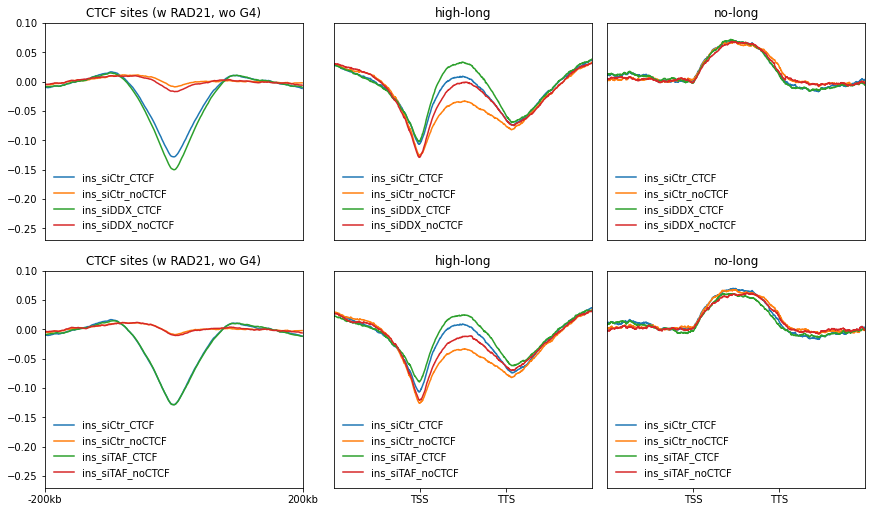

In [34]:
fig = plt.figure(figsize=(12,7),constrained_layout=True)
gs = fig.add_gridspec(2,3)
ins_ylim = (-0.27,.1)
rloop_ylim = (.7,4.5)

ins_keys_figure = [k for k in key_features if (k.startswith("ins_siCtr") or k.startswith("ins_siDDX")) ]
# insulation profiles around CTCF-peaks
ax = fig.add_subplot(gs[0,0])
for feature_name in ins_keys_figure:
    ins_profile = CTCF_profiles_dict[feature_name]
    ax.plot(ins_profile,label=feature_name)
ax.set_title(f"CTCF sites (w RAD21, wo G4)")
ax.legend(frameon=False)
ax.set_ylim(ins_ylim)
ax.set_xlim(0,300)
ax.set_xticks([])
ax.set_xticklabels([])

# insulation profiles around genes ...
glen="long"
gexps=("high","no")
for j, gexp in enumerate(gexps):
    ax = fig.add_subplot(gs[0,j+1])
    for feature_name in ins_keys_figure:
        ins_profiles = profiles_dict[feature_name]
        ax.plot(ins_profiles[(gexp,glen)],label=feature_name)
    ax.set_title(f"{gexp}-{glen}")
    ax.legend(frameon=False)
    ax.set_ylim(ins_ylim)
    ax.set_xlim(0,3000)
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])


ins_keys_figure = [k for k in key_features if (k.startswith("ins_siCtr") or k.startswith("ins_siTAF")) ]
# insulation profiles around CTCF-peaks
ax = fig.add_subplot(gs[1,0])
for feature_name in ins_keys_figure:
    ins_profile = CTCF_profiles_dict[feature_name]
    ax.plot(ins_profile,label=feature_name)
ax.set_title(f"CTCF sites (w RAD21, wo G4)")
ax.legend(frameon=False)
ax.set_ylim(ins_ylim)
ax.set_xlim(0,300)
ax.set_xticks([0,300])
ax.set_xticklabels(["-200kb","200kb"])

# insulation profiles around genes ...
glen="long"
gexps=("high","no")
for j, gexp in enumerate(gexps):
    ax = fig.add_subplot(gs[1,j+1])
    for feature_name in ins_keys_figure:
        ins_profiles = profiles_dict[feature_name]
        ax.plot(ins_profiles[(gexp,glen)],label=feature_name)
    ax.set_title(f"{gexp}-{glen}")
    ax.legend(frameon=False)
    ax.set_ylim(ins_ylim)
    ax.set_xlim(0,3000)
    ax.set_xticks([1000,2000])
    ax.set_xticklabels(["TSS","TTS"])
    ax.set_yticks([])
    ax.set_yticklabels([])

# plt.savefig("Figure6-siRNA-metaGene-insulation.pdf")    

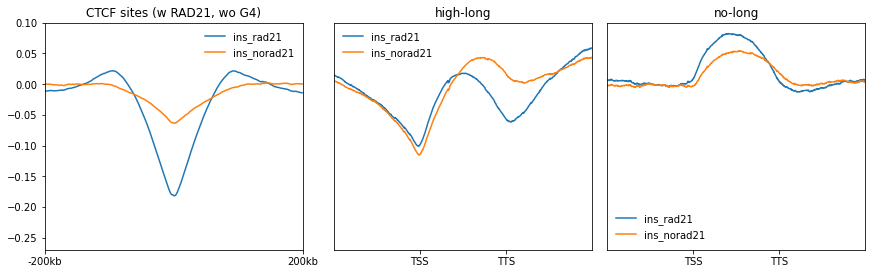

In [23]:
fig = plt.figure(figsize=(12,7),constrained_layout=True)
gs = fig.add_gridspec(2,3)
ins_ylim = (-0.27,.1)
rloop_ylim = (.7,4.5)

ins_keys_figure = ["ins_rad21","ins_norad21"]
# insulation profiles around CTCF-peaks
ax = fig.add_subplot(gs[1,0])
for feature_name in ins_keys_figure:
    ins_profile = CTCF_profiles_dict[feature_name]
    ax.plot(ins_profile,label=feature_name)
ax.set_title(f"CTCF sites (w RAD21, wo G4)")
ax.legend(frameon=False)
ax.set_ylim(ins_ylim)
ax.set_xlim(0,300)
ax.set_xticks([0,300])
ax.set_xticklabels(["-200kb","200kb"])

# insulation profiles around genes ...
glen="long"
gexps=("high","no")
for j, gexp in enumerate(gexps):
    ax = fig.add_subplot(gs[1,j+1])
    for feature_name in ins_keys_figure:
        ins_profiles = profiles_dict[feature_name]
        ax.plot(ins_profiles[(gexp,glen)],label=feature_name)
    ax.set_title(f"{gexp}-{glen}")
    ax.legend(frameon=False)
    ax.set_ylim(ins_ylim)
    ax.set_xlim(0,3000)
    ax.set_xticks([1000,2000])
    ax.set_xticklabels(["TSS","TTS"])
    ax.set_yticks([])
    ax.set_yticklabels([])

# plt.savefig("SuppFig3H-RAD21degron-metaGene-insulation-profile.pdf")

In [24]:
#! scp Figure6*pdf ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/
# ! scp SuppFig3H-RAD21degron-metaGene-insulation-profile.pdf ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/

In [32]:
! scp SuppFig3H-RAD21degron-metaGene-insulation-profile.pdf ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/

SuppFig3H-RAD21degron-metaGene-insulation-pro 100%  409KB 417.5KB/s   00:00    


In [112]:
! scp Figure6_unit_with_cpups*.pdf ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/

Figure6_unit_with_cpups_mutDDX.pdf            100%  696KB 324.7KB/s   00:02    
Figure6_unit_with_cpups_mutTAF.pdf            100%  700KB 286.1KB/s   00:02    
Figure6_unit_with_cpups.pdf                   100%  696KB 308.2KB/s   00:02    
Figure6_unit_with_cpups_siDDX.pdf             100%  723KB 315.2KB/s   00:02    
Figure6_unit_with_cpups_siTAF.pdf             100%  730KB 328.7KB/s   00:02    


In [33]:
## PlaB (splicing inhibition) two replicates pooled together
# ! scp ghpcc:/nl/umw_job_dekker/users/av90w/cooler/20210525_PlaB_same/NT-hg19-combined-90000000.mcool ./
# ! scp ghpcc:/nl/umw_job_dekker/users/av90w/cooler/20210525_PlaB_same/IAA-hg19-combined-90000000.mcool ./
# ! scp ghpcc:/nl/umw_job_dekker/users/av90w/cooler/20210525_PlaB_same/NT-PlaB-hg19-combined-90000000.mcool ./
# ! scp ghpcc:/nl/umw_job_dekker/users/av90w/cooler/20210525_PlaB_same/IAA-PlaB-hg19-combined-90000000.mcool ./


### Try generating Fig 6 - complete layout - i.e. average profiles and some coolpup heatmaps flipped on the side ...
`#!scp shadow:/data/venevs/ALV-repo/PUP_DICT_5kb_SHIFT_EXP.pickle ./`

In [65]:
from matplotlib import colors
import pickle
import scipy

In [115]:
# load pre-calculated coolpups ...
# !scp shadow:/data/venevs/ALV-repo/PUP_DICT_5kb_SHIFT_EXP.pickle ./
!scp shadow:/data/venevs/ALV-repo/PUP_DICT_5kb_SHIFT_EXP_4exp-size-groups.pickle ./
fp = open("PUP_DICT_5kb_SHIFT_EXP_4exp-size-groups.pickle","rb")
cpup_dict = pickle.load(fp)
fp.close()
#
cpup_samples = list(cpup_dict.keys())

PUP_DICT_5kb_SHIFT_EXP_4exp-size-groups.pickl 100%   94MB   1.4MB/s   01:07    


In [116]:
def get_cpup_hm(sample_name, gexp, gsize, flip45=True ):
    """
    extract cpup pileup from that huge dictionary for a given sample (exp,size)
    and also flip45 if requested ...
    """
    index_cols = ["gexp","gsize","orientation"]
    group_name = (gexp, gsize, '--')
    hm_minus = cpup_dict[sample_name].reset_index().set_index(index_cols).loc[group_name,"data"]
    group_name = (gexp, gsize, '++')
    hm_plus = cpup_dict[sample_name].reset_index().set_index(index_cols).loc[group_name,"data"]
    # [("med","long","--")]
    hm_average = 0.5*(hm_plus+hm_minus[::-1,::-1])
    if not flip45:
        return hm_average
    else:
        _hm = scipy.ndimage.rotate(hm_average,45,cval=np.nan,reshape=True)
        l,w = xxx.shape
        half_l = l//2
        # removing upper pic spitz vershina "verh == up"
        pic_hide = int(0.33*half_l)
        return _hm[pic_hide:half_l,:]


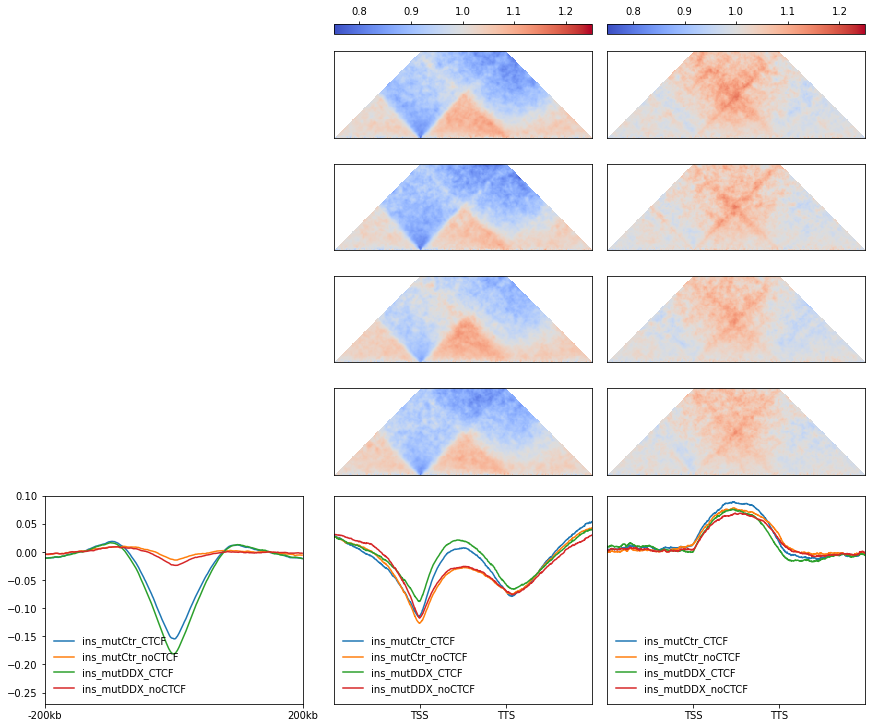

In [118]:
fig = plt.figure(figsize=(12,10),constrained_layout=True)
gs = fig.add_gridspec(1+4+1,3,height_ratios=[0.1,1,1,1,1,2])

fig6_cpup_samples = ['mutControl-NT.hg19', 'mutControl-IAA.hg19', 'mutDDX55-NT.hg19', 'mutDDX55-IAA.hg19']
# fig6_cpup_samples = ['mutControl-NT.hg19', 'mutControl-IAA.hg19', 'mutTAF5L-NT.hg19', 'mutTAF5L-IAA.hg19']
# fig6_cpup_samples = ['siControl-NT.hg19', 'siControl-IAA.hg19', 'siDDX55-NT.hg19', 'siDDX55-IAA.hg19']
# fig6_cpup_samples = ['siControl-NT.hg19', 'siControl-IAA.hg19', 'siTAF5L-NT.hg19', 'siTAF5L-IAA.hg19']

ins_keys_figure = [k for k in key_features if (k.startswith("ins_mutCtr") or k.startswith("ins_mutDDX")) ]
# ins_keys_figure = [k for k in key_features if (k.startswith("ins_mutCtr") or k.startswith("ins_mutTAF")) ]
# ins_keys_figure = [k for k in key_features if (k.startswith("ins_siCtr") or k.startswith("ins_siTAF")) ]
# insulation profiles around CTCF-peaks
ax = fig.add_subplot(gs[-1,0])
for feature_name in ins_keys_figure:
    ins_profile = CTCF_profiles_dict[feature_name]
    ax.plot(ins_profile,label=feature_name)
# ax.set_title(f"CTCF sites (w RAD21, wo G4)")
ax.legend(frameon=False)
ax.set_ylim(ins_ylim)
ax.set_xlim(0,300)
ax.set_xticks([0,300])
ax.set_xticklabels(["-200kb","200kb"])


# insulation profiles around genes ...
glen="long"
gexps=("high","no")
for j, gexp in enumerate(gexps):
    ax = fig.add_subplot(gs[-1,j+1])
    for feature_name in ins_keys_figure:
        ins_profiles = profiles_dict[feature_name]
        ax.plot(ins_profiles[(gexp,glen)],label=feature_name)
    ax.legend(frameon=False)
    ax.set_ylim(ins_ylim)
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_xlim(0,3000)
    ax.set_xticks([1000,2000])
    ax.set_xticklabels(["TSS","TTS"])

    
for j, cpup_sample in enumerate(fig6_cpup_samples):
    #
    # coolpups for expressed genes 
    ax = fig.add_subplot(gs[j+1,1])
    gexp, glen = "high", "long"
#     if j==0:
#         ax.set_title(f"{gexp}-{glen}")
    hhh = get_cpup_hm(cpup_sample, gexp, glen, flip45=True )
    cl = plt.imshow(hhh,interpolation="none",cmap="coolwarm",norm = colors.TwoSlopeNorm(vmin=0.75, vcenter=1, vmax=1.25))
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    # coolpups for non-expressed genes
    ax = fig.add_subplot(gs[j+1,2])
    gexp, glen = "no", "long"
#     if j==0:
#         ax.set_title(f"{gexp}-{glen}")
    hhh = get_cpup_hm(cpup_sample, gexp, glen, flip45=True )
    cr = plt.imshow(hhh,interpolation="none",cmap="coolwarm",norm = colors.TwoSlopeNorm(vmin=0.75, vcenter=1, vmax=1.25))
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])

# left color bar
ax = fig.add_subplot(gs[0,1])
# ax.xaxis.tick_top()
bar = plt.colorbar(cl, cax=ax, orientation="horizontal")
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 

# right color bar
ax = fig.add_subplot(gs[0,2])
# ax.xaxis.tick_top()
bar = plt.colorbar(cr, cax=ax, orientation="horizontal")
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 


# plt.savefig("Figure6_unit_with_cpups_siTAF.pdf")

In [113]:
cpup_samples

['CkoCT442_NT_pool.hg19',
 'CkoCT442_IAA_pool.hg19',
 'PolII-NT.hg19',
 'PolII-IAA.hg19',
 'mutControl-NT.hg19',
 'mutControl-IAA.hg19',
 'mutDDX55-NT.hg19',
 'mutDDX55-IAA.hg19',
 'mutTAF5L-NT.hg19',
 'mutTAF5L-IAA.hg19',
 'siControl-NT.hg19',
 'siControl-IAA.hg19',
 'siDDX55-NT.hg19',
 'siDDX55-IAA.hg19',
 'siTAF5L-NT.hg19',
 'siTAF5L-IAA.hg19',
 'RAD21-NT.hg19',
 'RAD21-IAA.hg19',
 'CtrlPlaB-NT.hg19',
 'CtrlPlaB-IAA.hg19',
 'PlaB-NT.hg19',
 'PlaB-IAA.hg19',
 'Ctrl500M-noTIR1.hg19',
 'Ctrl500M-wtHAP1.hg19',
 'Ctrl500M-CT442-NT.hg19',
 'Ctrl500M-CT442-IAA.hg19']

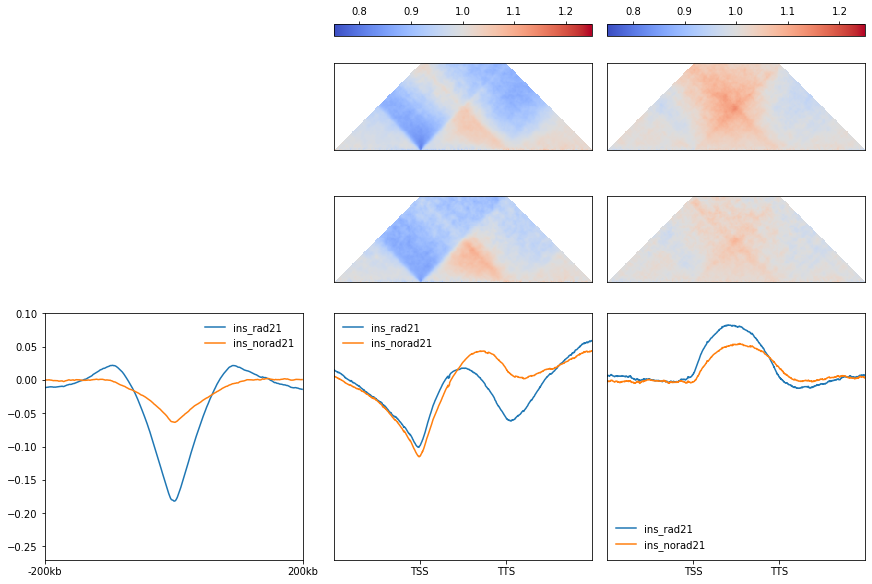

In [122]:
fig = plt.figure(figsize=(12,8),constrained_layout=True)
gs = fig.add_gridspec(1+2+1,3,height_ratios=[0.1,1,1,2])

fig6_cpup_samples = ['RAD21-NT.hg19', 'RAD21-IAA.hg19']
ins_keys_figure = ["ins_rad21","ins_norad21"]
# insulation profiles around CTCF-peaks
ax = fig.add_subplot(gs[-1,0])
for feature_name in ins_keys_figure:
    ins_profile = CTCF_profiles_dict[feature_name]
    ax.plot(ins_profile,label=feature_name)
# ax.set_title(f"CTCF sites (w RAD21, wo G4)")
ax.legend(frameon=False)
ax.set_ylim(ins_ylim)
ax.set_xlim(0,300)
ax.set_xticks([0,300])
ax.set_xticklabels(["-200kb","200kb"])


# insulation profiles around genes ...
glen="long"
gexps=("high","no")
for j, gexp in enumerate(gexps):
    ax = fig.add_subplot(gs[-1,j+1])
    for feature_name in ins_keys_figure:
        ins_profiles = profiles_dict[feature_name]
        ax.plot(ins_profiles[(gexp,glen)],label=feature_name)
    ax.legend(frameon=False)
    ax.set_ylim(ins_ylim)
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_xlim(0,3000)
    ax.set_xticks([1000,2000])
    ax.set_xticklabels(["TSS","TTS"])

    
for j, cpup_sample in enumerate(fig6_cpup_samples):
    #
    # coolpups for expressed genes 
    ax = fig.add_subplot(gs[j+1,1])
    gexp, glen = "high", "long"
#     if j==0:
#         ax.set_title(f"{gexp}-{glen}")
    hhh = get_cpup_hm(cpup_sample, gexp, glen, flip45=True )
    cl = plt.imshow(hhh,interpolation="none",cmap="coolwarm",norm = colors.TwoSlopeNorm(vmin=0.75, vcenter=1, vmax=1.25))
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    # coolpups for non-expressed genes
    ax = fig.add_subplot(gs[j+1,2])
    gexp, glen = "no", "long"
#     if j==0:
#         ax.set_title(f"{gexp}-{glen}")
    hhh = get_cpup_hm(cpup_sample, gexp, glen, flip45=True )
    cr = plt.imshow(hhh,interpolation="none",cmap="coolwarm",norm = colors.TwoSlopeNorm(vmin=0.75, vcenter=1, vmax=1.25))
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])

# left color bar
ax = fig.add_subplot(gs[0,1])
# ax.xaxis.tick_top()
bar = plt.colorbar(cl, cax=ax, orientation="horizontal")
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 

# right color bar
ax = fig.add_subplot(gs[0,2])
# ax.xaxis.tick_top()
bar = plt.colorbar(cr, cax=ax, orientation="horizontal")
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 


# plt.savefig("Figure6_unit_with_cpups_siTAF.pdf")

In [ ]:
glens=("short","medium","long")
gexps=("no","low","med","high")


fig = plt.figure(figsize=(12,8),constrained_layout=True)
gs = fig.add_gridspec(len(glens),len(gexps))
orient="--"

_yyyy = pup_dict["Ctrl500M-wtHAP1.hg19"].reset_index().set_index(["gexp","gsize","orientation"])

# divnorm = colors.TwoSlopeNorm(vmin=0.75, vcenter=1, vmax=1.25)

for i,glen in enumerate(glens):
    for j,gexp in enumerate(gexps):
        ax = fig.add_subplot(gs[i,j])
        pup_heatmap = _yyyy.loc[(gexp,glen,orient),"data"]
        img = ax.imshow(
            pup_heatmap,
#             norm = MidPointLogNorm(vmin=0.4,vmax=1.1,midpoint=1),
            norm = colors.TwoSlopeNorm(vmin=0.75, vcenter=1, vmax=1.25),
            cmap="coolwarm",
            interpolation="nearest",            
        )
        ax.set_title(f"{gexp}-{glen}-{orient}") 
plt.colorbar(img)